In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

root= Path.cwd()
if root.name == "notebooks":
    root = root.parent

plt.rcParams["figure.figsize"] = (10, 4)

RAW_XLS = root /  "data" / "raw" / "Base_Muestra_B2B.xlsx"

df = pd.read_excel(RAW_XLS, sheet_name=0, dtype={"Msisdn":"string"})
df.columns = df.columns.str.strip()

print("Shape:", df.shape)
df.head(3)


Shape: (218443, 22)


,Fuente,Periodo,Fecha Evento,Gerencia,Regional,Producto,Interfaz,Msisdn,Tecnologia,Ciudad,...,CANAL_N2,CANAL_N3,Cantidad,Fecha Churn,Mes Churn,Tipo Transaccion,Motivo,ejecutivo_id,Nuevo Segmento,Nombre Canal
0,Movil,202402,2024-02-14,Micro/Small,BOGOTA,Pospago 5.0,TIGO,3013566157,MOVIL,BOGOTA D.C.,...,TELEVENTAS,TELEVENTAS,1,NaN,NaN,NaN,NaN,1570024,Medianas,TELEVENTAS SALIDA PYMES
1,Movil,202402,2024-02-27,Micro/Small,BOGOTA,Pospago 5.4,TIGO,3001786032,MOVIL,BOGOTA D.C.,...,Hunter,Hunter,1,NaN,NaN,NaN,NaN,97510014,Medianas,EMTELCO-PQEM
2,Movil,202402,2024-02-02,Micro/Small,SUR,Pospago 5.0,TIGO,3002546253,MOVIL,RISARALDA,...,Agencias,RED DE DISTRIBUIDORES,1,NaN,NaN,NaN,NaN,1536135,Medianas,KAVANTIC S.A.S


In [3]:
# Hacemos exploración de tipos, nulos y duplicados

# Parseamos fechas si existen
for c in ["Fecha Evento","Fecha Churn"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Normalizamos Periodo a AAAA-MM (si existe), cubriendo 'YYYY-MM' y 'YYYMM'
if "Periodo" in df.columns:
    p = df["Periodo"].astype("string").str.strip()
    # 1) intenta 'YYYY-MM'
    per = pd.to_datetime(p, format="%Y-%m", errors="coerce")
    # 2) donde falló, intenta 'YYYYMM'
    mask = per.isna()
    per.loc[mask] = pd.to_datetime(p[mask], format="%Y%m", errors="coerce")
    df["Periodo_norm"] = per.dt.to_period("M").astype("string")
else:
    df["Periodo_norm"] = df["Fecha Evento"].dt.to_period("M").astype("string")

# Fallback: si aún hay NaN, usa Fecha Evento
mask2 = df["Periodo_norm"].isna() & df["Fecha Evento"].notna()
df.loc[mask2, "Periodo_norm"] = df.loc[mask2, "Fecha Evento"].dt.to_period("M").astype("string")

display(df.dtypes)

na_rate = df.isna().mean().sort_values(ascending=False)
display(na_rate.to_frame("pct_nulos").head(15))

dup_keys = [c for c in ["Msisdn","Fecha Evento","Producto","Nombre Canal"] if c in df.columns]
if dup_keys:
    print("Posibles duplicados por", dup_keys, ":", df.duplicated(subset=dup_keys).sum())


Fuente                      object
Periodo                      int64
Fecha Evento        datetime64[ns]
Gerencia                    object
Regional                    object
Producto                    object
Interfaz                    object
Msisdn              string[python]
Tecnologia                  object
Ciudad                      object
Nivel                       object
CANAL_N1                    object
CANAL_N2                    object
CANAL_N3                    object
Cantidad                     int64
Fecha Churn         datetime64[ns]
Mes Churn                  float64
Tipo Transaccion            object
Motivo                      object
ejecutivo_id                object
Nuevo Segmento              object
Nombre Canal                object
Periodo_norm        string[python]
dtype: object

,pct_nulos
Motivo,0.761997
Tipo Transaccion,0.761265
Fecha Churn,0.761265
Mes Churn,0.761265
Nuevo Segmento,0.380447
Nombre Canal,0.088435
Nivel,0.002252
ejecutivo_id,0.002110
Msisdn,0.000398
Producto,0.000357


Posibles duplicados por ['Msisdn', 'Fecha Evento', 'Producto', 'Nombre Canal'] : 85


min val: 1
max val: 600


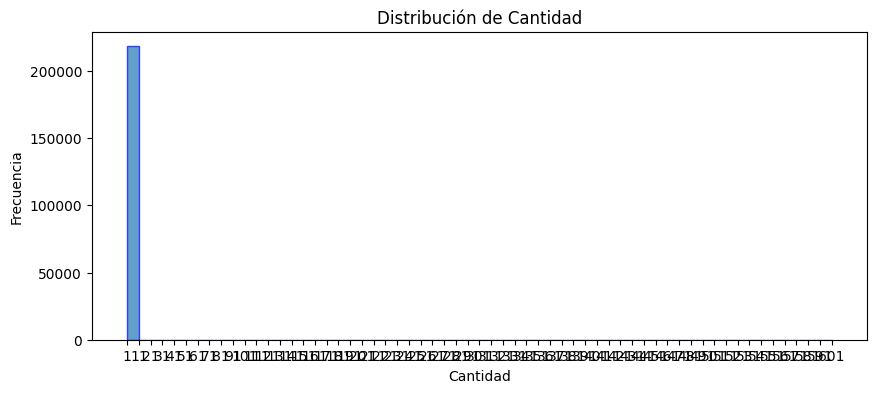

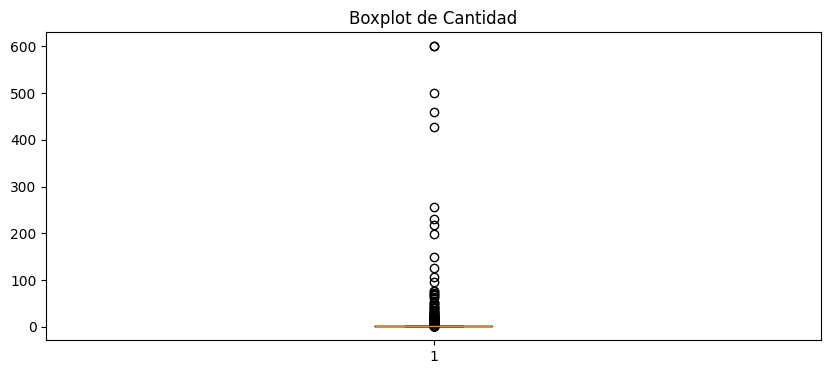

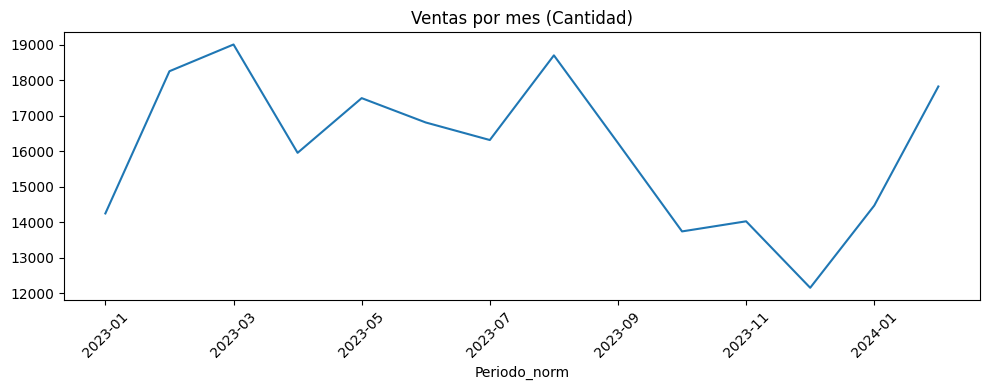

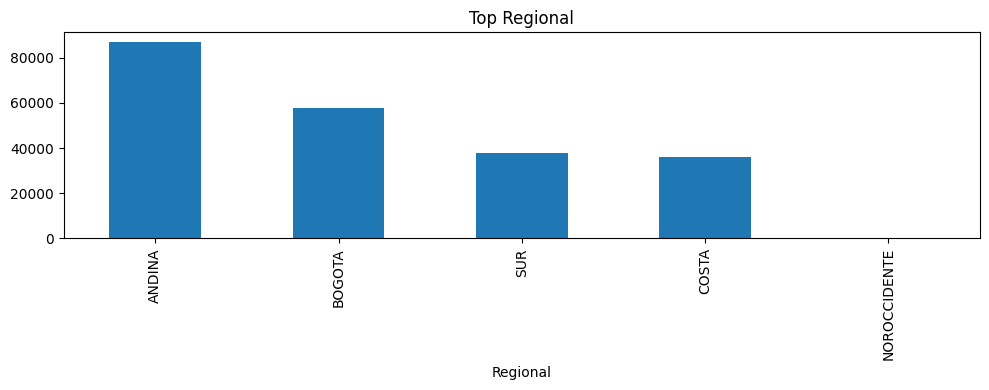

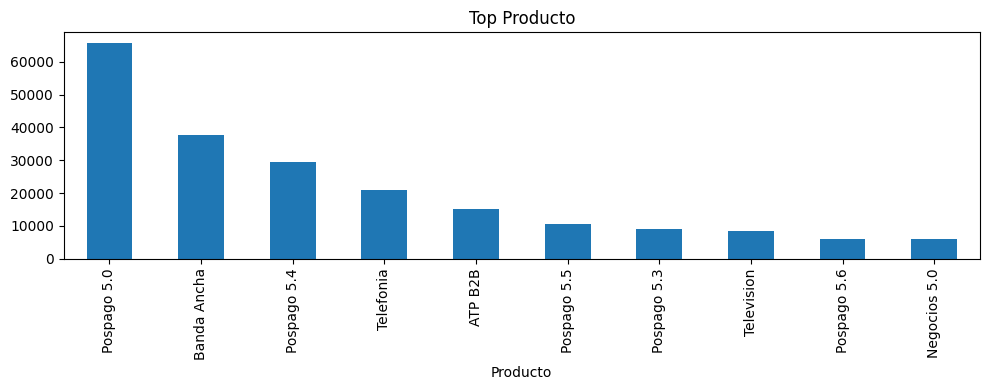

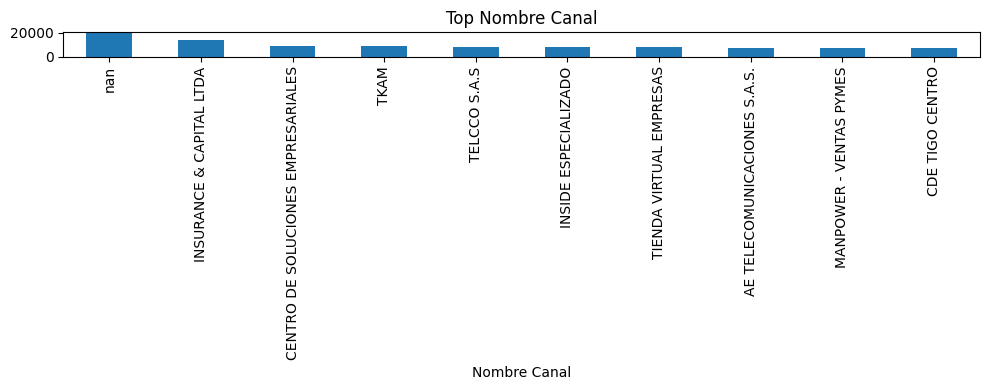

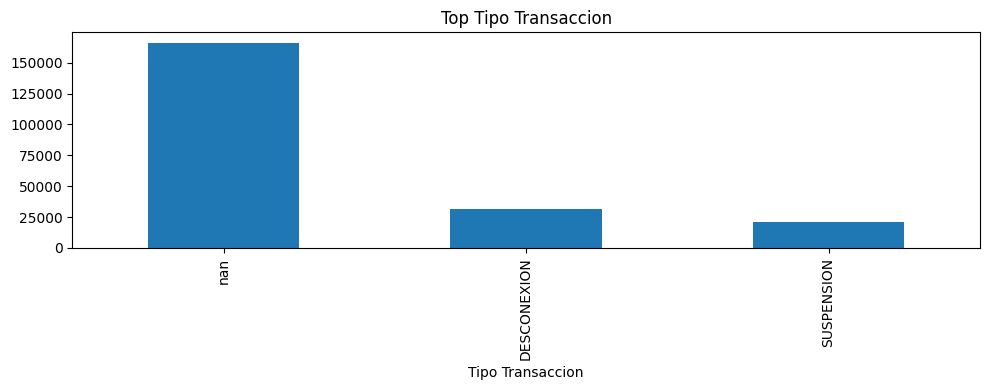

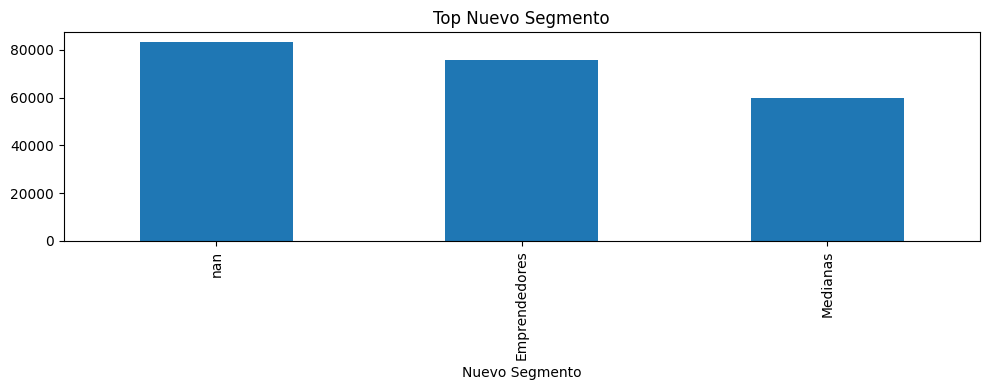

In [4]:
# Hacemos exploración de la data con histogramas y boxplots para darnos una idea general de la data.

# Eliminamos filas con cantidad negativas, ya que es imposible tener cantidades negativas en este contexto
df = df[df["Cantidad"] >= 0]


# Boxplot de Columna Cantidad
if "Cantidad" in df.columns:
    df["Cantidad"] = pd.to_numeric(df["Cantidad"], errors="coerce")
    
    data = df["Cantidad"].dropna()
    
    min_val=int(data.min())
    max_val=int(data.max())

    print(f"min val: {min_val}")
    print(f"max val: {max_val}")

    #Creamos el array para mostrar de 10 en 10
    bins_10= np.arange(min_val,max_val+10, 10)

    plt.hist(data, bins=bins_10, edgecolor='blue', alpha=0.7)
    plt.title("Distribución de Cantidad")
    plt.xlabel("Cantidad")
    plt.ylabel("Frecuencia")
    plt.xticks(bins_10)
    plt.show()

    plt.boxplot(data)
    plt.title("Boxplot de Cantidad")
    plt.show()

# Columna Ventas por mes
ventas_mes = df.groupby("Periodo_norm", dropna=False)["Cantidad"].sum().sort_index()
ventas_mes.plot()
plt.title("Ventas por mes (Cantidad)"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Top categorías
for col in ["Regional","Producto","Nombre Canal","Tipo Transaccion","Nuevo Segmento"]:
    if col in df.columns:
        df[col].value_counts(dropna=False).head(10).plot(kind="bar")
        plt.title(f"Top {col}"); plt.tight_layout(); plt.show()


Proporción con churn: 0.23873614048580402


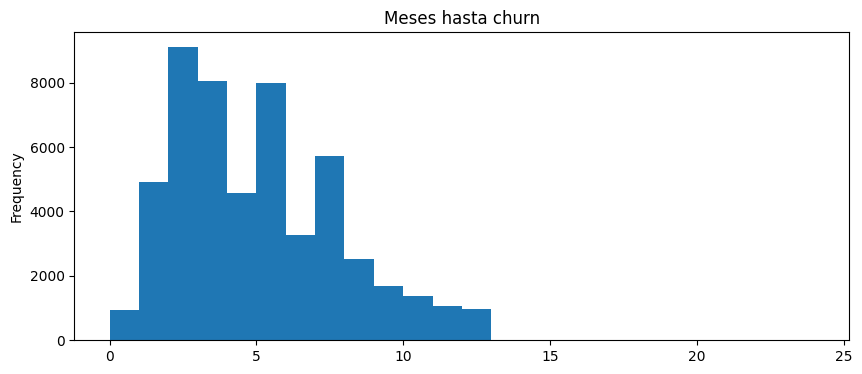

In [5]:
# Hacemos proporción del Churn

if "Fecha Churn" in df.columns:
    df["tiene_churn"] = df["Fecha Churn"].notna()
    print("Proporción con churn:", df["tiene_churn"].mean())

def months_diff(a,b):
    if pd.isna(a) or pd.isna(b): return np.nan
    return (b.year - a.year)*12 + (b.month - a.month)

if all(c in df.columns for c in ["Fecha Evento","Fecha Churn"]):
    df["Mes Churn"] = [months_diff(a,b) for a,b in zip(df["Fecha Evento"], df["Fecha Churn"])]
    df["Mes Churn"].dropna().astype(int).plot(kind="hist", bins=range(0,25))
    plt.title("Meses hasta churn"); plt.show()


In [6]:
# Ahora realizamos normalización, limpieza y exportamos a CSV

# Normalizamos tipo de churn
if "Tipo Transaccion" in df.columns:
    df["Tipo Transaccion"] = (df["Tipo Transaccion"]
                              .astype("string").str.strip().str.lower()
                              .replace({"churn voluntario":"voluntario",
                                        "churn x cartera":"cartera"}))
    df["Tipo Transaccion"] = df["Tipo Transaccion"].fillna("desconocido")

# Removemos duplicados, analizando por 4 columnas dónde según esta data no debería de haber números repetidos
keys = [c for c in ["Msisdn","Fecha Evento","Producto","Nombre Canal"] if c in df.columns]
if keys:
    before = len(df)
    df = df.drop_duplicates(subset=keys, keep="first")
    print("Filas removidas por duplicado:", before - len(df))

# Guardamos CSV limpio
Path("data/processed").mkdir(parents=True, exist_ok=True)
OUT_CSV = "data/processed/fact_ventas_churn.csv"
df.to_csv(OUT_CSV, index=False)
print("OK →", OUT_CSV, "(", len(df), "filas )")


Filas removidas por duplicado: 85
OK → data/processed/fact_ventas_churn.csv ( 218357 filas )


In [8]:
import pandas as pd
from pathlib import Path
import numpy as np

df = pd.read_csv("data/processed/fact_ventas_churn.csv", dtype={"Msisdn":"string"})
# fechas
for c in ["Fecha Evento","Fecha Churn"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Periodo_norm si no existe
if "Periodo_norm" not in df.columns:
    df["Periodo_norm"] = df["Fecha Evento"].dt.to_period("M").astype("string")

# Altas por mes (ventas)
altas_m = df.groupby("Periodo_norm", dropna=False)["Cantidad"].sum().rename("altas").reset_index()

# Churn por mes (cuenta líneas con Fecha Churn en ese mes)
df["Mes_Churn_Periodo"] = df["Fecha Churn"].dt.to_period("M").astype("string")
churn_m = (
    df.loc[df["Fecha Churn"].notna()]
      .groupby("Mes_Churn_Periodo")["Cantidad"].sum()
      .rename("churn")
      .reset_index()
      .rename(columns={"Mes_Churn_Periodo":"Periodo_norm"})
)

kpi = pd.merge(altas_m, churn_m, on="Periodo_norm", how="outer").fillna(0)
kpi = kpi.sort_values("Periodo_norm", ignore_index=True)

# Base expuesta aprox: acumulado de altas - acumulado de churn del mes PREVIO
kpi["cum_altas"] = kpi["altas"].cumsum()
kpi["cum_churn"] = kpi["churn"].cumsum()
kpi["base_prev"] = (kpi["cum_altas"] - kpi["cum_churn"]).shift(1)
kpi["base_prev"] = kpi["base_prev"].clip(lower=0).fillna(0)

kpi["churn_rate"] = np.where(kpi["base_prev"]>0, kpi["churn"]/kpi["base_prev"], np.nan)
kpi["net_adds"] = kpi["altas"] - kpi["churn"]

Path("data/processed").mkdir(parents=True, exist_ok=True)
kpi.to_csv("data/processed/kpis_mensuales.csv", index=False)
kpi.head(12)


,Periodo_norm,altas,churn,cum_altas,cum_churn,base_prev,churn_rate,net_adds
0,2023-01,14246,67,14246,67,0.0,NaN,14179
1,2023-02,18258,378,32504,445,14179.0,0.026659,17880
2,2023-03,18984,1396,51488,1841,32059.0,0.043545,17588
3,2023-04,15956,1708,67444,3549,49647.0,0.034403,14248
4,2023-05,17472,2837,84916,6386,63895.0,0.044401,14635
5,2023-06,16784,2917,101700,9303,78530.0,0.037145,13867
6,2023-07,16317,3503,118017,12806,92397.0,0.037912,12814
7,2023-08,18706,4333,136723,17139,105211.0,0.041184,14373
8,2023-09,16233,5035,152956,22174,119584.0,0.042104,11198
9,2023-10,13738,5942,166694,28116,130782.0,0.045434,7796
